In [ ]:
# imports 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from glob import glob
from tqdm import notebook
from sklearn import preprocessing
from keras import Model
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers
import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import sys, os
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.models import model_from_json
import h5py
import tensorflow as tf
from sklearn.model_selection import train_test_split
from skimage.transform import resize

***
Opening Data 
***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = '/content/drive/My Drive/datachallenge/data_train_images.h5'

In [ ]:
h5f = h5py.File(train,'r')
train_images = h5f['data_train_images'][:]
h5f.close()


In [ ]:
h5f = h5py.File('/content/drive/My Drive/datachallenge/data_train_labels.h5','r')
train_labels = h5f['data_train_labels'][:]
h5f.close()

In [ ]:
h5f = h5py.File('/content/drive/My Drive/datachallenge/data_test_images.h5','r')
test_images= h5f['data_test_images'][:]
h5f.close()

In [ ]:
fer_image = np.load('/content/drive/My Drive/datachallenge/images.npy')
fer_classes = np.load('/content/drive/My Drive/datachallenge/classes.npy')

In [ ]:
# adapting fer-2013 dataset
fer_classes = np.load('classes.npy')
angry = np.where(fer_classes==0)
disgust = np.where(fer_classes==1)
fear = np.where(fer_classes==2)
happy = np.where(fer_classes==3)
sad = np.where(fer_classes==5)
suprise = np.where(fer_classes==6)
deleter = np.where(fer_classes==4)


FileNotFoundError: ignored

In [ ]:
fer_classes = np.delete(fer_classes, deleter)

In [ ]:

fer_classes[angry] = 3
fer_classes[disgust] = 4
fer_classes[happy] = 0
fer_classes[sad] = 5
fer_classes[suprise] = 2
fer_classes[fear] = 1


In [ ]:
test = np.zeros((test_images.shape[0],48,48,3))

In [ ]:
# adding channels
for i in range(test_images.shape[0]):
  img = resize(test_images[i,-1,:,:], (48,48),
                       anti_aliasing=True)
  test[i,:,:,0]=img
  test[i,:,:,1]=img
  test[i,:,:,1]=img

In [ ]:
fer_images =np.delete(fer_image,np.where(lala==4),axis=0)

In [ ]:
fer_classes = np.delete(fer_classes, np.where(lala==4))

***
Pre-process data 
***

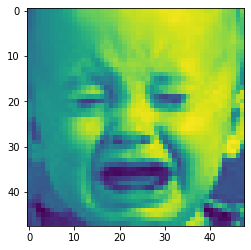

In [ ]:
plt.imshow(fer_image[78])

In [ ]:
# add channells
X_lal = fer_image
X = np.zeros((X_lal.shape[0], X_lal.shape[1], X_lal.shape[2],3))

X[:,:,:,0] = X_lal
X[:,:,:,1] = X_lal
X[:,:,:,2] = X_lal

In [ ]:
fer_images.shape

(29689, 48, 48)

In [ ]:
fer_classes.shape

(29689,)

In [ ]:
# using only the last image
X_f = train_images[:, -1, :,:].copy()
X_f = np.squeeze(X_f)
X = np.zeros( (X_f.shape[0], X_f.shape[1],X_f.shape[2], 3 ) )


X[:,:,:,0] = X_f
X[:,:,:,1] = X_f
X[:,:,:,2] = X_f




In [ ]:
X_t = test_images[:, -1, :,:].copy()
X_t = np.squeeze(X_t)
X_train = np.zeros( (X_t.shape[0], X_t.shape[1],X_t.shape[2], 3 ) )


X_train[:,:,:,0] = X_t
X_train[:,:,:,1] = X_t
X_train[:,:,:,2] = X_t

In [ ]:
# one hot encoding
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(fer_classes.reshape(29689,1))
y =enc.transform(fer_classes.reshape(29689,1)).toarray()

In [ ]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)


In [ ]:
BATCH_SIZE = 16
num_classes = 6 

In [ ]:
# tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)
)
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

test_dataset = test_dataset.batch(BATCH_SIZE)

***
2D CNN
***

In [ ]:
# github with pretrained classifier
pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-ah5nh5h2
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-ah5nh5h2
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 2.5 MB/s 
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20046 sha256=78e04db900e50716d32e425266a1a64e83c376bc841d381b095db4c3721dface
  Stored in directory: /tmp/pip-ephem-wheel-cache-au4isnz4/wheels/0b/96/56/27b17c903efc647c51e4f364bfc20aa67f8d3dccad63c4fb4e
Successfully built image-classifiers


In [ ]:
# for keras
from classification_models.tfkeras import Classifiers

# for tensorflow.keras
# from classification_models.tfkeras import Classifiers

ResNet, preprocess_input = Classifiers.get('resnet18')


In [ ]:
n_classes = 6


In [ ]:
# build model
base_model = ResNet(input_shape=(48,48,3), weights='imagenet', include_top=False)
base_model.trainable = False


In [ ]:
# normalize
rescale = tf.keras.layers.Rescaling(1./255)

In [ ]:
tf.image.sobel_edges()

TypeError: ignored

In [ ]:
# building model 
inputs = tf.keras.Input(shape=(48, 48, 3))
x = rescale(inputs)
x = base_model(x)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(264, activation='relu')(x)
x = keras.layers.Dense(128,activation='relu')(x) 
x = keras.layers.Dense(64,activation='relu')(x)
output = keras.layers.Dense(n_classes, activation='relu')(x)
model = keras.models.Model(inputs=[inputs], outputs=[output])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 model_5 (Functional)        (None, 2, 2, 512)         11186889  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 264)               135432    
                                                                 
 dense_13 (Dense)            (None, 128)               33920     
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                           

In [ ]:
model.load_weights('/content/drive/My Drive/datachallenge/weights')


In [ ]:
# train

model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model.fit(train_dataset,
                    epochs=5,
                    validation_data=test_dataset)

Epoch 1/5
1763/1763 [==============================] - 73s 40ms/step - loss: nan - accuracy: 0.4463 - val_loss: 1.4734 - val_accuracy: 0.4444


KeyboardInterrupt: ignored

In [ ]:
np.argmax(model.predict(test),axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
model.save_weights('/content/drive/My Drive/datachallenge/weights')


In [ ]:
base_model.summary().shape

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 bn_data (BatchNormalization)   (None, 48, 48, 3)    9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_36 (ZeroPadding  (None, 54, 54, 3)   0           ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv0 (Conv2D)                 (None, 24, 24, 64)   9408        ['zero_padding2d_36[0][0]']

## fine tuning


In [ ]:
# Unfreeze top layer 
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate =0.0001)


In [ ]:
def scheduler(epoch, lr):
  if epoch < 1:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback1 = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7)
callback3 = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/datachallenge/weights',
                                                 save_weights_only=True,
                                                 verbose=1)


In [ ]:
fine_tune_epochs = 10
initial_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

model.fit(train_dataset,epochs=total_epochs,
                         initial_epoch=40,
                         validation_data=test_dataset, verbose=1, callbacks=[callback1,callback2,callback3])

initial_epochs = total_epochs

In [ ]:
model.fit(X_train, y,
                batch_size=10,
                epochs=5,
                verbose=1,
                validation_split=0.2)

Epoch 1/5
2255/2257 [============================>.] - ETA: 0s - loss: 1.7634 - accuracy: 0.3899

KeyboardInterrupt: ignored

In [ ]:
initial_epochs = 40 

In [ ]:
pred = model.predict(X_train)

In [ ]:
np.argmax(pred,axis=1)

array([1, 5, 1, 1, 4, 2, 4, 4, 1, 0, 4, 1, 1, 4, 1, 5, 4, 2, 1, 4, 2, 5,
       5, 2, 3, 4, 3, 0, 3, 4, 1, 0, 2, 0, 0, 2, 3, 0, 2, 0, 3, 2, 5, 4,
       2, 4, 3, 2, 4, 4, 1, 0, 4, 2, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 3,
       1, 2, 1, 3, 2, 1, 4, 1, 0, 1, 1, 3, 0, 2, 1, 4, 1, 1, 1, 1, 0, 1,
       1, 4, 4, 1, 0, 0, 2, 3, 4, 1, 0, 5, 1, 3, 4, 1, 0, 5, 2, 1, 4, 4,
       4, 4, 1, 5, 1, 1, 0, 1, 1, 5, 4, 1, 4, 5, 1, 1, 1, 1, 5, 1, 1])

In [ ]:
model.save_model()

AttributeError: ignored

In [ ]:
sample_submission = pd.read_csv("/content/drive/My Drive/datachallenge/sampleSubmission.csv")


sample_submission["expression"] = np.argmax(pred,axis=1)

sample_submission.to_csv("/content/drive/My Drive/datachallenge/sampleSubmission.csv", index=False)

***
VGG

***

In [ ]:
base_model1 = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights='imagenet', input_shape=(48,48,3), pooling=None, classes=n_classes,
    classifier_activation='softmax'
)

58900480/58889256 [==============================] - 2s 0us/step


In [ ]:
# build model
inputs = tf.keras.Input(shape=(48, 48, 3))
x = base_model1(inputs)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(264, activation='softmax')(x)
x = keras.layers.Dense(128,activation='softmax')(x) 
x = keras.layers.Dense(64,activation='softmax')(x)
output = keras.layers.Dense(n_classes, activation='softmax')(x)
model1 = keras.models.Model(inputs=[inputs], outputs=[output])
model1.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d_8   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 264)               135432    
                                                                 
 dense_19 (Dense)            (None, 128)               33920     
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                          

In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [ ]:
model1.fit(train_dataset,
                    epochs=15,
                    validation_data=test_dataset)

Epoch 1/15
 827/3526 [======>.......................] - ETA: 2:34 - loss: 1.6947 - accuracy: 0.2946

KeyboardInterrupt: ignored

***
Efficient-Net
***

In [ ]:
import tensorflow as tf
model = tf.keras.applications.efficientnet.EfficientNetB7(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(300,200,3), pooling=None, classes=1000,
    classifier_activation='softmax'
)
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])



258088960/258076736 [==============================] - 2s 0us/step


In [ ]:
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X, y)

17/17 [==============================] - 46s 2s/step - loss: 1.5456 - accuracy: 0.3926
